In [3]:
import numpy as np
#cv2 a.k.a. opencv is a package for dealing with images
import cv2 as cv
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Getting and preprocessing data

In [4]:
#LOAD IMAGES
# chose this size so that it approximates images well but is also highly divisible by 2
# because some of the neural network layers shrink the size by factor of 2

XDIM = 2048
YDIM = 11*XDIM//8 

def load_marsh_images(folder):
    images = []
    
    for i in range(1,12):
        img = cv.imread(os.path.join(folder,"Band%d.jpg" % i))
        #print("Band%d.jpg" % i)
        if img is not None:
            #convert to black and white
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img = cv.resize(img,(YDIM, XDIM))
            #warp so the mask is square
            #img = cv.warpPerspective(img,Mpad,(SIZE+2*PAD,SIZE+2*PAD))
            images.append(img)
    return images

#get images with PIE thrown out

gce_imgs = load_marsh_images("train_jpg/GCE")
#pie_imgs = load_marsh_images("train_jpg/PIE")
vcr_imgs = load_marsh_images("train_jpg/VCR")
images = np.array([
    gce_imgs,
    #pie_imgs
    vcr_imgs])
NUM_IMG = images.shape[0]

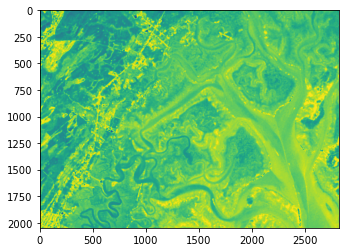

In [5]:
# view one of our beautiful images
plt.imshow(images[0,0,:,:])

In [6]:
#GET MASKS (not PIE)


gce_mask = cv.imread("new-masks/updated_GCE_mask.jpg")
#pie_mask = cv.imread("new-masks/updated_PIE_mask.jpg")
vcr_mask = cv.imread("new-masks/updated_VCR_map.jpg")

new_masks = [cv.cvtColor(gce_mask, cv.COLOR_BGR2GRAY), 
         #cv.cvtColor(pie_mask, cv.COLOR_BGR2GRAY), 
         cv.cvtColor(vcr_mask, cv.COLOR_BGR2GRAY)]
masks = []
for m in new_masks:
    m = cv.resize(m,(YDIM,XDIM))
    masks.append(m)
new_masks = masks

In [7]:
#PREPROCESS MASKS
#change the values in the mask to integers from 1 to 5 instead of the weird 
# 0-255 values currently in there. Ideally the GIS software would output them like 
# this already, but c'est la vie.

THRESH = [90,120,140,180] #found by exploring the data
new_masks = np.array(new_masks)
tidal_flat = (new_masks <= THRESH[0])
marsh = np.logical_and(THRESH[0] < new_masks, new_masks <= THRESH[1])
channel = np.logical_and(THRESH[1] < new_masks, new_masks <= THRESH[2])
upland = np.logical_and(THRESH[2] < new_masks, new_masks <= THRESH[3])
unlabeled = THRESH[3] < new_masks

#to throw away tidal_flat
unlabeled = np.logical_or(tidal_flat,unlabeled)
masks = [marsh,channel,upland,unlabeled]

int_mask = np.zeros_like(new_masks,dtype=int)
for i,m in enumerate(masks):
    int_mask = int_mask + i*m.astype(int)
masks = np.reshape(int_mask, (NUM_IMG,1,XDIM,YDIM))

#get frequencies of each class
ind,counts = np.unique(masks,return_counts=True)

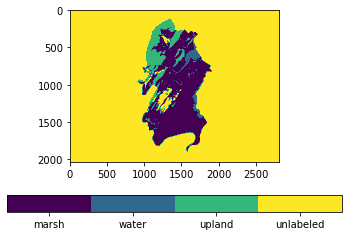

In [16]:
# view one of our beautiful masks
cmap = plt.cm.get_cmap('viridis', 4)
plt.imshow(masks[1,0,:,:],vmax=3,vmin=0,cmap=cmap)
cbar = plt.colorbar(ticks=[3/8 + i*(3.0/4.0) for i in range(4)],orientation='horizontal')
cbar.set_ticklabels([class_dict[i] for i in range(len(class_dict))])

In [17]:
# use the above image to set the marsh colors:

class_dict = {0: 'marsh', 1: 'water', 2: 'upland', 3: 'unlabeled'}

In [18]:
#TEST AND TRAIN SPLITS
# we need to hide part of each image from the neural net while training 
# so that we can later use the hidden part for testing.
# I do a naive thing where I just convert the upper 5/8 of the mask to the unknown class.
# I also convert to tensor (data format for tensorflow)

not_care = np.max(masks)

te_masks = np.zeros_like(masks)
tr_masks = np.zeros_like(masks)

te_masks.fill(not_care)
tr_masks.fill(not_care)

te_masks[:,0,:3*XDIM//8,:]=masks[:,0,:3*XDIM//8,:]
tr_masks[:,0,3*XDIM//8:,:]=masks[:,0,3*XDIM//8:,:]


def get_tensor(images):
    images_tensor = tf.convert_to_tensor(images,dtype =tf.float32)
    SAMPLES,BANDS,HEIGHT,WIDTH = images_tensor.shape
    image_tensor = tf.transpose(images_tensor,[0,2,3,1])
    return image_tensor

train_images = get_tensor(images)
train_masks = get_tensor(tr_masks)

test_images = get_tensor(images)

test_masks = get_tensor(te_masks)

2022-09-09 10:45:15.415623: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-09 10:45:15.415788: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


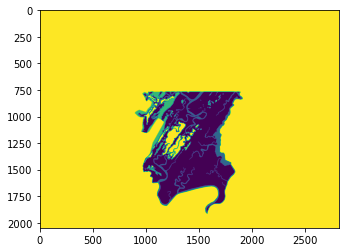

In [19]:
# view one of our training masks
plt.imshow(tr_masks[1,0])

In [20]:
#CREATE TENSORFLOW DATASET AND AUGMENT DATA
# datasets are a data format that makes training fast
# each augmentation transformation
#changes image and mask in exactly the same way

train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_masks))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_masks))


class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal_and_vertical",seed=seed),
      tf.keras.layers.RandomRotation(1.0,seed=seed),
      tf.keras.layers.RandomZoom(.5, .5,seed =seed)
    ])
    self.augment_labels = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal_and_vertical",seed=seed),
      tf.keras.layers.RandomRotation(1.0,seed=seed),
      tf.keras.layers.RandomZoom(.5, .5,seed =seed)
    ])
    
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

with tf.device('/cpu:0'):
    train_batches = (
    train_dataset
    .cache()
    .shuffle(NUM_IMG)
    .batch(NUM_IMG)
    #.repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(3)

# Defining our model

In [22]:
#linear regression model - no hidden layer

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #down
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=1,strides=1)(inputs)
    
    #x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [21]:
# DEFINE MODEL
# starting at inputs, each line is applied sequentially. 
# the output of each layer is an image (well, it may have many more than 3 bands)
# which will be fed into the next layer.
# finally the output will be an image with 4 (number of classes) bands 
# with the intensity at pixel p in class c reflecting the network's confidence that 
# that pixel p belongs to class c. 
# the mask is then created by assigning p to the class which has highest confidence.

#best one so far

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #down
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=2,strides=1,activation="relu",padding='same')(inputs)
    
    #maxpool
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2),padding='same')(x)
    
    x = tf.keras.layers.Conv2D(10,2,1,activation="relu",padding='same')(x)
    
    #maxpool
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2),padding='same')(x)
    
    #up
    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=5, kernel_size=2, strides=2,
    padding='same')
    
    x = last(x)
    
    #maxpool
    x = tf.keras.layers.Conv2D(output_channels,2,1,activation="relu",padding='same')(x)
    #x = tf.keras.layers.MaxPool2D(pool_size=(2, 2),padding='same')(x)

    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [27]:
# COMPILE THE MODEL

#4 classes when tidal flats are unlabeled 

OUTPUT_CLASSES = 4
#OUTPUT_CLASSES=5


model = shallow_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              weighted_metrics=['accuracy']
             )

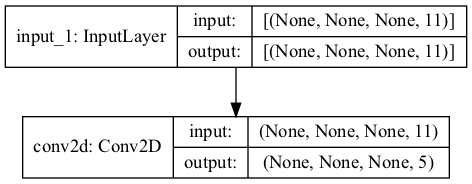

In [24]:
# look at architecture

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# summarize model

model.summary()

# Viewing model output

In [25]:
#VIEWING MODEL OUTPUT
# we should probably put legends for the classes, 
# otherwise its easy to get confused between colors

for image,mask in test_dataset.take(1):
    sample_image,sample_mask = image, mask
for image,mask in train_dataset.take(1):
    sample_train_image,sample_train_mask = image, mask

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image, mask[0,0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

def show_train_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0,0], create_mask(pred_mask)])
  else:
    display([sample_train_image, sample_train_mask,
             create_mask(model.predict(sample_train_image[tf.newaxis, ...]))])
    
def display(display_list):
  plt.figure(figsize=(20, 20))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.title(title[i])
    if display_list[i].shape[-1]==1:
        mi = 0
        ma = 3
    else:
        mi = 4
        ma = 7
    plt.imshow(tf.keras.utils.array_to_img(display_list[i][:,:,mi:ma]))
    plt.axis('off')
  plt.show()

2022-08-12 08:51:37.865599: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-12 08:51:37.896147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


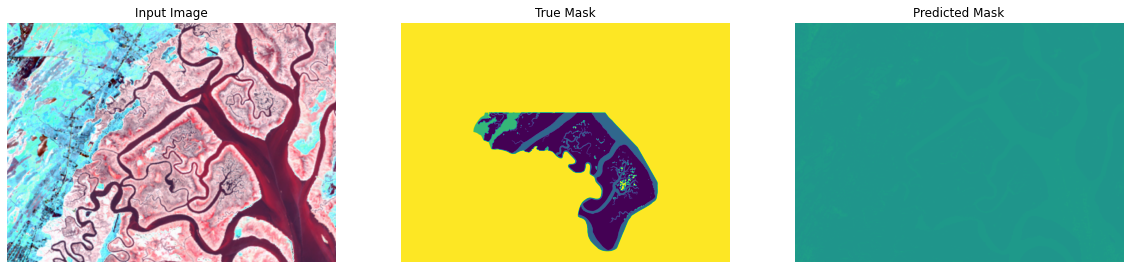

In [19]:
# check what our network outputs now
# if training hasn't happened should look totally random
show_train_predictions()

# Saving and loading

In [20]:
# SAVING AND LOADING
# be very careful to choose the filename so as not to overwrite a good model that 
# took hours or days to train!

#saving
model.save('saved-models/LinearRegressionDemo')

2022-08-12 08:54:34.511155: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved-models/GarbageDemoExample/assets


In [21]:
# loading
model = tf.keras.models.load_model('saved-models/Depth2Maxpool87val')

# Training

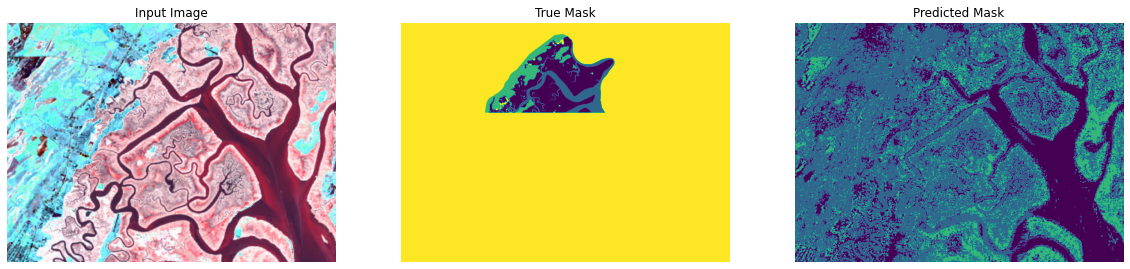


Sample Prediction after epoch 431

Epoch 432/1000
1/1 [==============================] - 5s 5s/step - loss: 0.4501 - accuracy: 0.0633 - weighted_accuracy: 0.3295 - val_loss: 0.4441 - val_accuracy: 0.0411 - val_weighted_accuracy: 0.2961

Sample Prediction after epoch 432

Epoch 433/1000
1/1 [==============================] - 5s 5s/step - loss: 0.6264 - accuracy: 0.0985 - weighted_accuracy: 0.3562 - val_loss: 0.4403 - val_accuracy: 0.0406 - val_weighted_accuracy: 0.2988

Sample Prediction after epoch 433

Epoch 434/1000


KeyboardInterrupt: 

In [28]:
#TRAINING MODEL

#callback is just to do display info during training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5==0:
        clear_output(wait=True)
        show_predictions()
    #show_train_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    
# be careful to send your logs to a useful filename, right now it's /logs/Demo

tb_callback = tf.keras.callbacks.TensorBoard('./logs/LinearRegressionDemo', update_freq=5)

## adding sample weights so that the final class is ignored 

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1/counts[0],1/counts[1],1/counts[2], 0.0])
  #class_weights = tf.constant(inv_freq)
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

#actually training 

EPOCHS = 1000
# 10 epochs for demo 
#change to 3000 or so to retrain for real

model_history = model.fit(train_batches.map(add_sample_weights), 
                          #class_weight = {0:1,1:1,2:1,3:1,4:0},
                          epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches.map(add_sample_weights),
                          callbacks=[DisplayCallback(),tb_callback]
                         )

# logging

In [26]:
# change to reload_ext
%load_ext tensorboard

In [27]:
%tensorboard --logdir logs/